In [1]:
"""3-Class Mental Health Classifier (DistilBERT)"""

!pip install -q datasets "transformers[torch]" accelerate scikit-learn pandas || true


In [2]:
import gc
import re
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import accuracy_score, f1_score, classification_report

from torch.nn import CrossEntropyLoss

import pandas as pd

In [3]:
FILE_PATH = "/content/mental_health.csv"

TEXT_COL  = "statement"
LABEL_COL = "status"

In [4]:
# Load dataset
df = pd.read_csv(FILE_PATH)

print("Columns:", df.columns.tolist())
print("Unique raw labels:", df[LABEL_COL].unique())

label_to_3class = {
    # NORMAL
    "normal": "normal",
    "supportive": "normal",
    "neutral": "normal",

    # STRESS + ANXIETY
    "anxiety": "stress_anxiety",
    "stress": "stress_anxiety",
    "anger": "stress_anxiety",

    # DEPRESSED
    "depression": "depressed",
    "suicidal": "depressed",
}

Columns: ['Unnamed: 0', 'statement', 'status']
Unique raw labels: ['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


In [5]:
# Apply mapping
df["mh_label_text"] = df[LABEL_COL].str.lower().map(label_to_3class)

In [6]:
# Drop rows that don't match mapping
df = df.dropna(subset=["mh_label_text", TEXT_COL]).reset_index(drop=True)

In [7]:
print("\nAfter 3-class mapping:")
print(df["mh_label_text"].value_counts())


After 3-class mapping:
mh_label_text
depressed         26056
normal            16343
stress_anxiety     6428
Name: count, dtype: int64


In [8]:
# Encode to numbers
classes = ["normal", "stress_anxiety", "depressed"]
label2id = {c: i for i, c in enumerate(classes)}
id2label = {i: c for c, i in label2id.items()}

df["label"] = df["mh_label_text"].map(label2id)

df.head()

,Unnamed: 0,statement,status,mh_label_text,label
0,0,oh my gosh,Anxiety,stress_anxiety,1
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,stress_anxiety,1
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,stress_anxiety,1
3,3,I've shifted my focus to something else but I'...,Anxiety,stress_anxiety,1
4,4,"I'm restless and restless, it's been a month n...",Anxiety,stress_anxiety,1


In [9]:
#DEVICE & CLEANUP
torch.cuda.empty_cache()
gc.collect()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [10]:
#  TRAIN/VAL/TEST SPLIT
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])

print("\nSplit sizes:")
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

train_ds = Dataset.from_pandas(train_df[[TEXT_COL, "label"]])
val_ds   = Dataset.from_pandas(val_df[[TEXT_COL, "label"]])
test_ds  = Dataset.from_pandas(test_df[[TEXT_COL, "label"]])

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})


Split sizes:
Train: 34178 Val: 7324 Test: 7325


In [11]:
# TOKENIZER & MODEL
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def clean_text(text: str) -> str:
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#[A-Za-z0-9_]+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def tokenize(batch):
    texts = [clean_text(t) for t in batch[TEXT_COL]]
    return tokenizer(
        texts,
        truncation=True,
        padding=False,
        max_length=128,
    )

tokenized = dataset.map(tokenize, batched=True)

# Set correct label column name for Trainer
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(classes),
    id2label=id2label,
    label2id=label2id,
)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)
model.to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/34178 [00:00<?, ? examples/s]

Map:   0%|          | 0/7324 [00:00<?, ? examples/s]

Map:   0%|          | 0/7325 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# METRICS
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
    }


In [13]:
# TRAINING ARGS
args = TrainingArguments(
    output_dir="./mh_3class_distil",
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    save_steps=10_000_000,
    save_total_limit=1,
    report_to="none",
)


In [14]:
# TRAINING ARGS
args = TrainingArguments(
    output_dir="./mh_3class_distil",
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    save_steps=10_000_000,
    save_total_limit=1,
    report_to="none",
)

In [15]:
# TRAINER
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\nStarting training...")
trainer.train()
print("Training finished.")

trainer.save_model("./mh_3class_distil_final")
tokenizer.save_pretrained("./mh_3class_distil_final")
print("Model saved at ./mh_3class_distil_final")

/tmp/ipython-input-928707909.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting training...


Step,Training Loss
100,0.638200
200,0.339700
300,0.286900
400,0.242100
500,0.214200
600,0.235100
700,0.212200
800,0.205700
900,0.226200
1000,0.187600


Training finished.
Model saved at ./mh_3class_distil_final


In [16]:
#FINAL EVAL
print("\nEvaluating on TEST set...")
test_pred = trainer.predict(tokenized["test"])
logits_test = test_pred.predictions
labels_test = test_pred.label_ids
preds_test = logits_test.argmax(axis=-1)

print("\n=== FINAL TEST METRICS ===")
print("Accuracy:", accuracy_score(labels_test, preds_test))
print("Macro F1:", f1_score(labels_test, preds_test, average="macro", zero_division=0))
print("\nPer-class classification report:")
print(classification_report(labels_test, preds_test, target_names=classes, zero_division=0))


Evaluating on TEST set...



=== FINAL TEST METRICS ===
Accuracy: 0.9490784982935153
Macro F1: 0.9288362609973534

Per-class classification report:
                precision    recall  f1-score   support

        normal       0.95      0.94      0.95      2452
stress_anxiety       0.85      0.89      0.87       964
     depressed       0.97      0.97      0.97      3909

      accuracy                           0.95      7325
     macro avg       0.92      0.93      0.93      7325
  weighted avg       0.95      0.95      0.95      7325



In [17]:
#INFERENCE HELPER
def predict_text(text: str):
    text_clean = clean_text(text)
    inputs = tokenizer(text_clean, return_tensors="pt", truncation=True, max_length=128).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    pred_id = int(probs.argmax())
    pred_label = id2label[pred_id]

    return {
        "predicted_class": pred_label,
        "scores": {id2label[i]: float(probs[i]) for i in range(len(classes))}
    }

print("\nExample prediction:")
print(predict_text("I feel completely hopeless and nothing will ever get better."))


Example prediction:
{'predicted_class': 'depressed', 'scores': {'normal': 0.00016562170640099794, 'stress_anxiety': 0.0005602910532616079, 'depressed': 0.9992741942405701}}


In [18]:
!zip -r mh_3class_distil_final.zip mh_3class_distil_final


  adding: mh_3class_distil_final/ (stored 0%)
  adding: mh_3class_distil_final/training_args.bin (deflated 53%)
  adding: mh_3class_distil_final/tokenizer.json (deflated 71%)
  adding: mh_3class_distil_final/vocab.txt (deflated 53%)
  adding: mh_3class_distil_final/special_tokens_map.json (deflated 42%)
  adding: mh_3class_distil_final/model.safetensors (deflated 8%)
  adding: mh_3class_distil_final/tokenizer_config.json (deflated 75%)
  adding: mh_3class_distil_final/config.json (deflated 49%)


In [19]:
from google.colab import files
files.download("mh_3class_distil_final.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import seaborn as sns


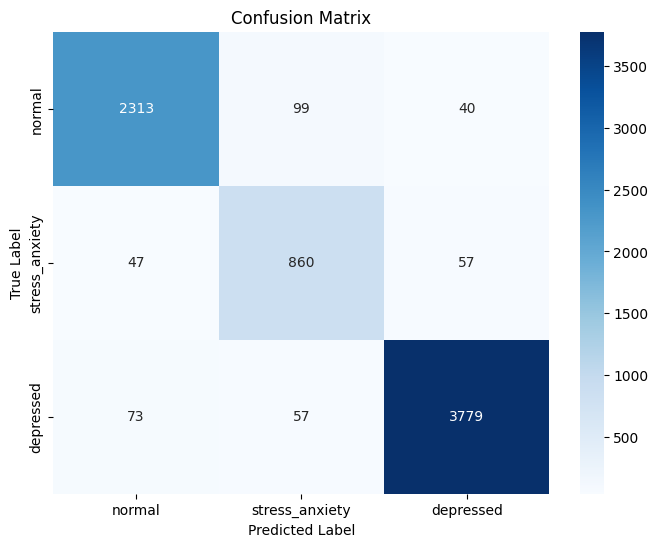

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(labels_test, preds_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()